In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import random

In [43]:
# random seed
random.seed(21)
np.random.seed(21)

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

### Load the dataset

In [44]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
99818,00026444_001.png,No Finding,1,26444,81,M,PA,2992,2991,0.143,0.143,NaN
31515,00008232_018.png,Emphysema|Infiltration,18,8232,41,M,AP,2500,2048,0.168,0.168,NaN
90941,00022663_000.png,No Finding,0,22663,55,M,PA,2992,2991,0.143,0.143,NaN


In [45]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70587,00017406_001.png,No Finding,1,17406,63,M,PA,2048,2500,0.168000,0.168000,NaN,/data/images_008/images/00017406_001.png
24741,00006500_001.png,No Finding,1,6500,55,M,PA,2500,2048,0.168000,0.168000,NaN,/data/images_003/images/00006500_001.png
110965,00030271_000.png,Nodule,0,30271,55,M,PA,2020,2021,0.194311,0.194311,NaN,/data/images_012/images/00030271_000.png


data shape and data types of each column in `all_xray_df`

In [46]:
all_xray_df.shape

(112120, 13)

In [47]:
all_xray_df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
path                            object
dtype: object

The statistics of some columns

In [48]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


We have noticed the max age is 414, there may be something wrong with Patient Age, let's check the patients got age larger than 100.

In [49]:
all_xray_df[all_xray_df['Patient Age'] >= 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_003/images/00005567_000.png
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,/data/images_006/images/00011973_002.png
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012238_010.png
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,/data/images_007/images/00013950_000.png
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014520_026.png
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015558_000.png
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,/data/images_008/images/00018366_044.png
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,/data/images_009/images/00019346_000.png
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020900_002.png
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021047_002.png


The ratio of records got 'Patient Age' >= 100

In [50]:
len(all_xray_df[all_xray_df['Patient Age'] >= 100]) / len(all_xray_df)

0.00014270424545130217

Drop the records got 'Patient Age' >= 100

In [51]:
all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] >= 100].index, inplace = True)

### Age

Age distribution of the dataset

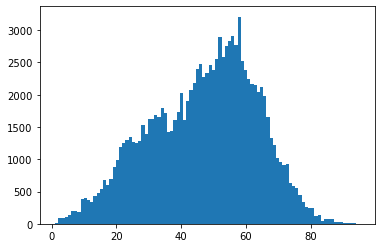

In [52]:
fig_patient_age = plt.hist(all_xray_df['Patient Age'], bins = 'auto')

In [53]:
all_xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

We can see the age range from 1 to 95, mean age is 46

### Gender

In [54]:
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

In [55]:
all_xray_df['Patient Gender'].value_counts()['M'] / all_xray_df['Patient Gender'].value_counts()['F'] 

1.298343447597179

There is more male than female in the dataset, the ratio is about 1.3 : 1

### Helper funtions to extract and show sample images from dataset

In [56]:
def get_images(df, img_path, col, val, k):
    """
    return a list of k images from dataset that df[col] == val
    """
    images = [plt.imread(img) for img in list(df[df[col] == val].sample(k)[img_path])]
    return images

In [57]:
def show_sample_plots(images, rows, columns):
    """
    show images in subplots of rows * columns
    """
    fig=plt.figure(figsize=(15, 10))
    for i in range(1, columns*rows +1):
        img = images[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap = 'gray')
    plt.show()

In [58]:
def show_pixel_intensity_plots(images, rows, columns):
    """
    show the distribution of pixel intensity values of images in subplots of rows * columns
    """
    fig=plt.figure(figsize=(15, 10))
    for i in range(1, columns*rows +1):
        img = images[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.hist(img.ravel(), bins = 256)
        plt.ylim(0, 25000)
    plt.show()

### View Positoin

In [59]:
all_xray_df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

There is more PA than AP in the dataset

In [60]:
all_xray_df['View Position'].value_counts()['AP'] / len(all_xray_df)

0.39967351744808394

About 40% of the dataset if 'AP

Take a few samples and check the difference between PA and AP

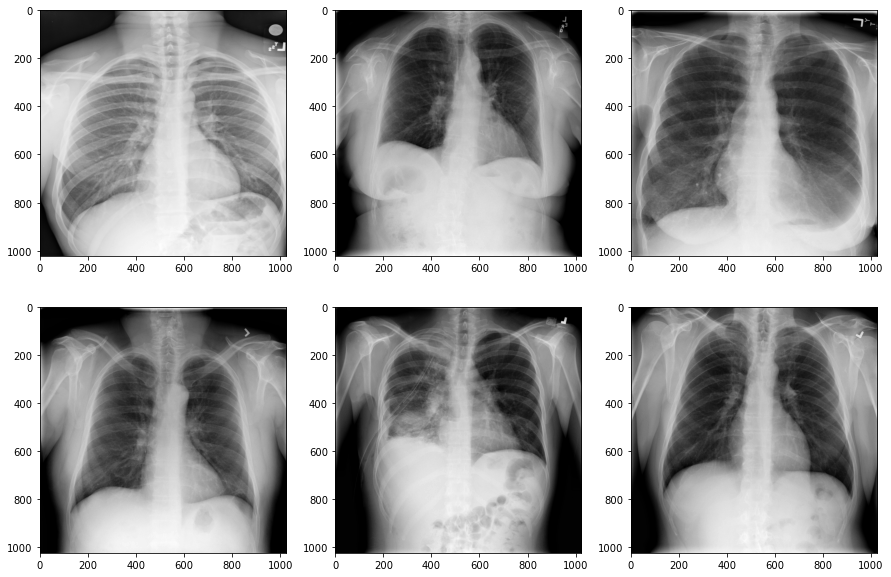

In [61]:
show_sample_plots(get_images(all_xray_df, 'path', 'View Position', 'PA', 6), 2, 3)

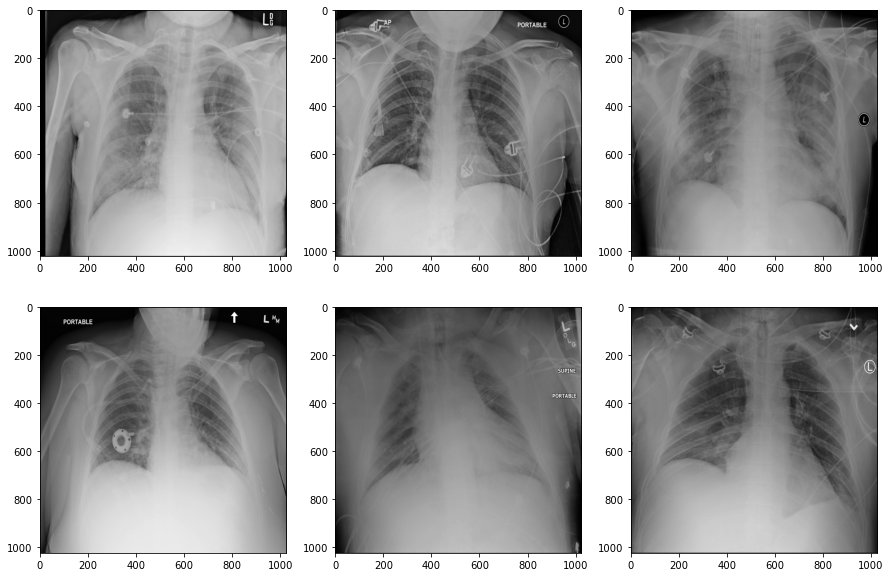

In [62]:
show_sample_plots(get_images(all_xray_df, 'path', 'View Position', 'AP', 6), 2, 3)

### Follow Up

In [63]:
all_xray_df['Follow-up #'].describe()

count    112104.000000
mean          8.574172
std          15.406734
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

In [64]:
all_xray_df['Follow-up #'].value_counts()

0      30797
1      13301
2       9186
3       7088
4       5759
       ...  
181        1
174        1
180        1
178        1
173        1
Name: Follow-up #, Length: 184, dtype: int64

In [65]:
all_xray_df['Follow-up #'].value_counts()[0]/len(all_xray_df)

0.2747181188896025

The mean Follow up number is 8.57, 27.4%  for image got no Follow Up

### Patient ID

Group the 'Image Index' by 'Patient ID'

In [66]:
patient_id_df = all_xray_df.groupby(['Patient ID'])['Image Index'].agg(
    lambda x: tuple([y for y in x if y is not np.nan ] ) ).reset_index()

In [67]:
patient_id_df.shape

(30802, 2)

Length of patient_id than the length of dataset, use 'image_counts' to record the image records of per patient_id

In [68]:
patient_id_df['image_counts'] = patient_id_df['Image Index'].str.len()

Distribution of 'image_counts' to diferent 'Patient_ID'

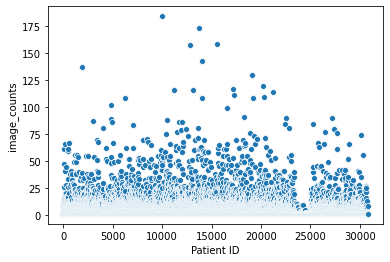

In [69]:
sns.scatterplot(x = "Patient ID", y = 'image_counts', data =patient_id_df)

In [70]:
patient_id_df['image_counts'].value_counts()

1      17501
2       4112
3       2101
4       1330
5        938
       ...  
111        1
87         1
102        1
117        1
119        1
Name: image_counts, Length: 103, dtype: int64

Some patient_id got more than 1 image records

In [71]:
(len(patient_id_df) - patient_id_df['image_counts'].value_counts()[1]) / len(patient_id_df)

0.4318226089214986

We can see that 43% of the patients got more than 1 image, to prevent data leakage we need to split the patient before data analysis

### Finding Labels

Find all unique labels in the 'Finding Labels'

In [72]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].str.split('|'))))
all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [73]:
len(all_labels)

15

There are 15 labels, one of them is 'No Finding'

Append a column to the dataset for each label 

In [74]:
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].str.contains(label, regex = False)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
46618,00011907_002.png,No Finding,2,11907,37,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,False,False,False,False
43565,00011237_029.png,Consolidation|Infiltration,29,11237,56,F,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,False,False
42478,00010932_007.png,No Finding,7,10932,56,M,PA,2894,2991,0.143,...,False,False,False,False,False,True,False,False,False,False
17036,00004571_004.png,No Finding,4,4571,72,M,PA,2500,2048,0.171,...,False,False,False,False,False,True,False,False,False,False
97004,00025580_001.png,No Finding,1,25580,45,M,AP,3056,2544,0.139,...,False,False,False,False,False,True,False,False,False,False


Let's check the distribution of different labels

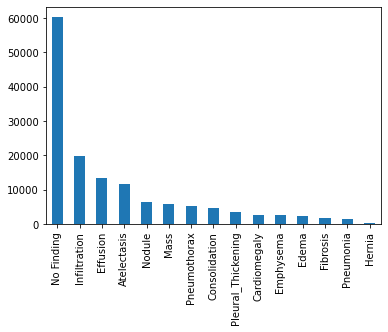

In [75]:
all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')

In [76]:
all_xray_df[all_labels].sum().sort_values(ascending=False)/len(all_xray_df)

No Finding            0.538366
Infiltration          0.177433
Effusion              0.118783
Atelectasis           0.103101
Nodule                0.056474
Mass                  0.051550
Pneumothorax          0.047286
Consolidation         0.041631
Pleural_Thickening    0.030186
Cardiomegaly          0.024763
Emphysema             0.022443
Edema                 0.020535
Fibrosis              0.015040
Pneumonia             0.012756
Hernia                0.002025
dtype: float64

* 53.8% of the images are 'No Finding'.
* 'Infiltration', 'Effusion', and 'Atelectasis' are the top 3 diseases in the dataset.
* 1.27% of the images are 'Pneumonia' positive

Check the correlation of different labels

In [77]:
all_xray_df[all_labels].corr()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.015817,0.108945,-0.003379,0.172462,0.032598,0.011128,0.010830,0.093157,0.018995,-0.366142,-0.007972,0.025221,0.029948,0.031437
Cardiomegaly,0.015817,1.000000,0.015355,0.028331,0.130096,-0.007093,0.004834,0.001761,0.014191,-0.010670,-0.172081,-0.012128,0.009126,0.002859,-0.022249
Consolidation,0.108945,0.015355,1.000000,0.020835,0.101130,-0.000526,0.003233,-0.005414,0.045931,0.074610,-0.225077,0.031812,0.028742,0.025257,0.000487
Edema,-0.003379,0.028331,0.020835,1.000000,0.062127,-0.009200,-0.013241,-0.002325,0.094265,0.002939,-0.156364,0.000271,-0.002018,0.174110,-0.022479
Effusion,0.172462,0.130096,0.101130,0.062127,1.000000,0.011195,-0.002779,-0.003658,0.118164,0.070770,-0.396483,0.019109,0.072037,0.024112,0.047587
Emphysema,0.032598,-0.007093,-0.000526,-0.009200,0.011195,1.000000,-0.000910,-0.001466,0.000406,0.023232,-0.163630,-0.007067,0.026416,-0.004880,0.178194
Fibrosis,0.011128,0.004834,0.003233,-0.013241,-0.002779,-0.000910,1.000000,0.007477,0.008796,0.009972,-0.133444,0.022474,0.053590,-0.006862,0.000095
Hernia,0.010830,0.001761,-0.005414,-0.002325,-0.003658,-0.001466,0.007477,1.000000,-0.003780,0.011934,-0.048644,-0.002424,0.001331,0.000185,-0.001621
Infiltration,0.093157,0.014191,0.045931,0.094265,0.118164,0.000406,0.008796,-0.003780,1.000000,0.013898,-0.501559,0.042754,0.020411,0.073088,0.000597
Mass,0.018995,-0.010670,0.074610,0.002939,0.070770,0.023232,0.009972,0.011934,0.013898,1.000000,-0.251767,0.101300,0.065206,-0.000977,0.029980


The corr-efficience of 'Pneumonia' and 'Edema' are high(0.174), let's check the image and pixel intensity profile of them. 
We will also check 'No Findings'.
Because an image may have multiple labels, we will use the col 'Finding Labels' to filter the images.

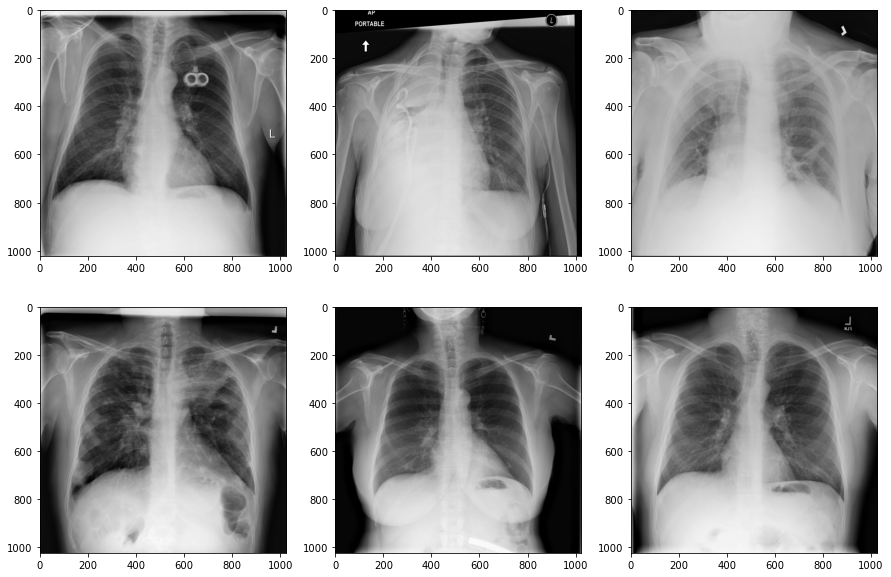

In [78]:
pneumonia_images = get_images(all_xray_df, 'path', 'Finding Labels', 'Pneumonia', 6)
show_sample_plots(pneumonia_images, 2, 3)

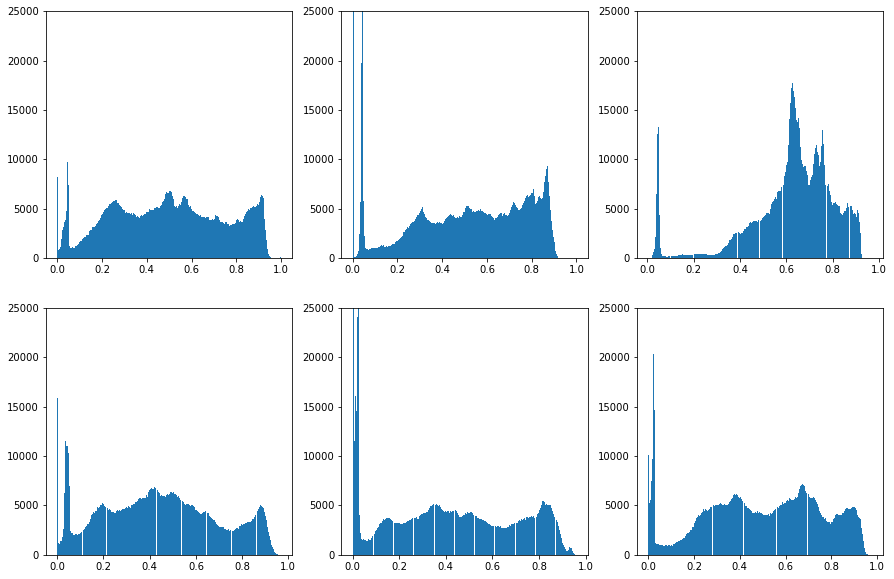

In [79]:
show_pixel_intensity_plots(pneumonia_images, 2, 3)

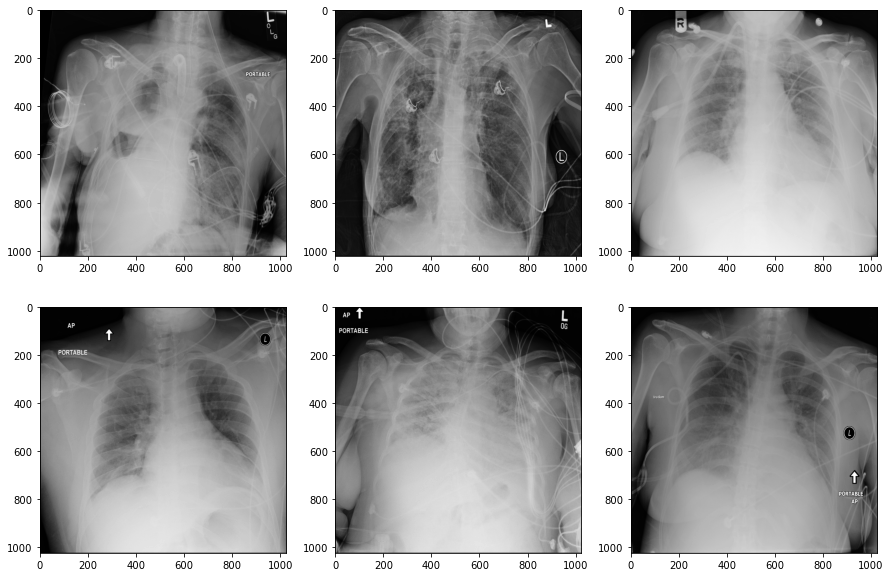

In [80]:
edema_images = get_images(all_xray_df, 'path', 'Finding Labels', 'Edema', 6)
show_sample_plots(edema_images, 2, 3)

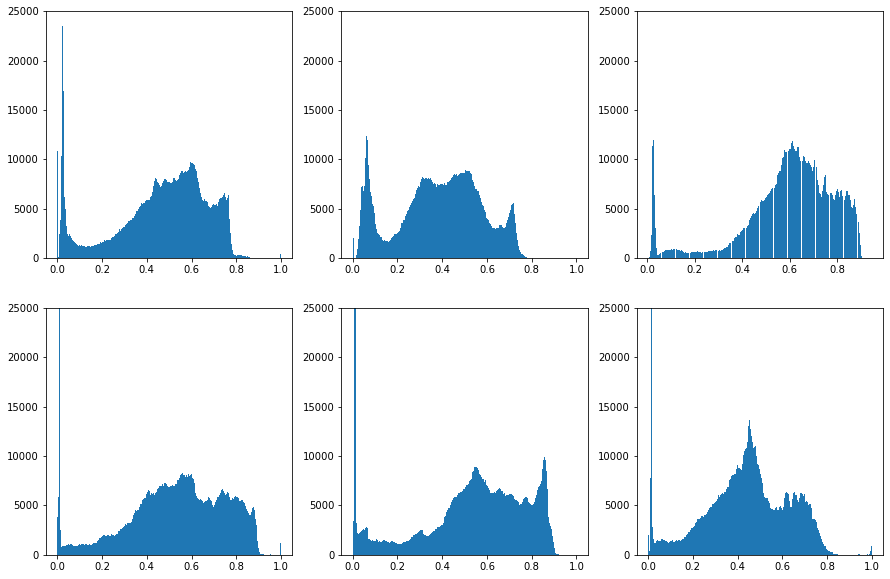

In [81]:
show_pixel_intensity_plots(edema_images, 2, 3)

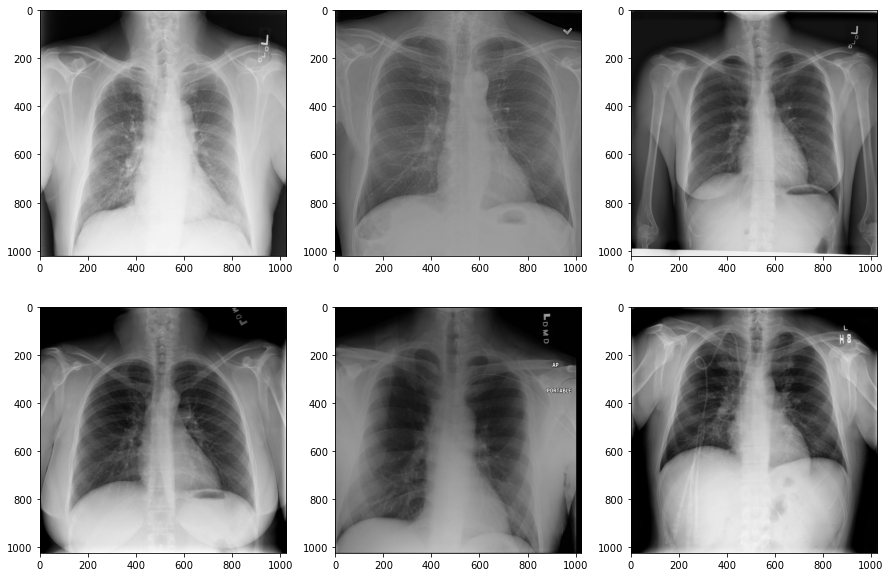

In [82]:
no_finding_images = get_images(all_xray_df, 'path', 'Finding Labels', 'No Finding', 6)
show_sample_plots(no_finding_images, 2, 3)

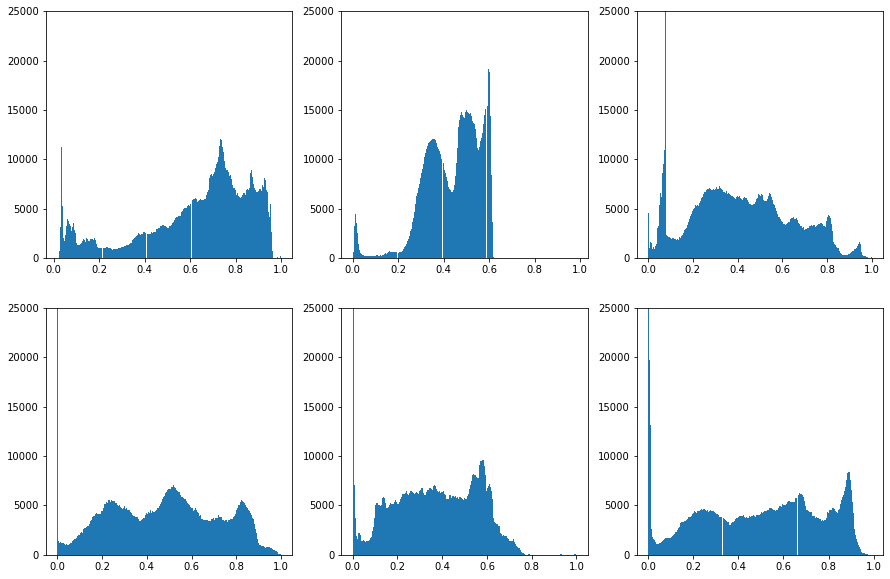

In [83]:
show_pixel_intensity_plots(no_finding_images, 2, 3)

We can see that 'No Finding' and 'Edema' got one or more peaks in their pixel intensity profile while most of the 'Pneumonia' got no clear peaks.
However, the pixel intensity profiles within group are also quiet different.

### Pneumonia
Next, we will focus on Pnemuona positve dataset
First of all, let's check other diseases distribution in 'Pnemonia' positive dataset

In [84]:
pneumonia_data = all_xray_df[all_xray_df['Pneumonia'] == True]

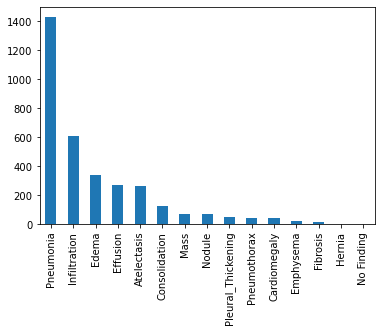

In [85]:
pneumonia_data[all_labels].sum().sort_values(ascending=False).plot(kind='bar')

In [86]:
pneumonia_data[all_labels].sum().sort_values(ascending=False)/len(pneumonia_data)

Pneumonia             1.000000
Infiltration          0.423077
Edema                 0.237762
Effusion              0.187413
Atelectasis           0.183217
Consolidation         0.086014
Mass                  0.049650
Nodule                0.048951
Pleural_Thickening    0.033566
Pneumothorax          0.028671
Cardiomegaly          0.028671
Emphysema             0.016084
Fibrosis              0.007692
Hernia                0.002098
No Finding            0.000000
dtype: float64

The distribution of other disease in the pneumonia positive dataset is similar to the original dataset except 'Edema', which may have correlation with 'Pneumonia'

In [46]:
pneumonia_data['Patient Age'].describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

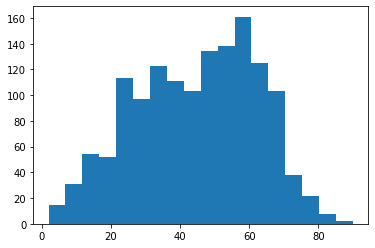

In [78]:
pneumonia_patient_age = plt.hist(pneumonia_data['Patient Age'], bins = 'auto')

In [47]:
pneumonia_data['Patient Gender'].value_counts()

M    837
F    593
Name: Patient Gender, dtype: int64

In [48]:
pneumonia_data['Patient Gender'].value_counts()['M'] / pneumonia_data['Patient Gender'].value_counts()['F']

1.4114671163575043

The gender and age distritbution'Pneumonia' positive samples is similar to the original dataset.

In [50]:
pneumonia_data['View Position'].value_counts()

AP    800
PA    630
Name: View Position, dtype: int64

In [51]:
pneumonia_data['View Position'].value_counts()['AP'] / len(pneumonia_data)

0.5594405594405595

The 'View Position' of 'AP' is more common in 'Pneumonia' positive data than the whole dataset

"Atelectasis", "Edema",   "Effusion", "Infiltration" are the most common lables. Besides "Edema", the other three are also the most common labels in the whole dataset. Let's check the picture and pix intensity profile of them.

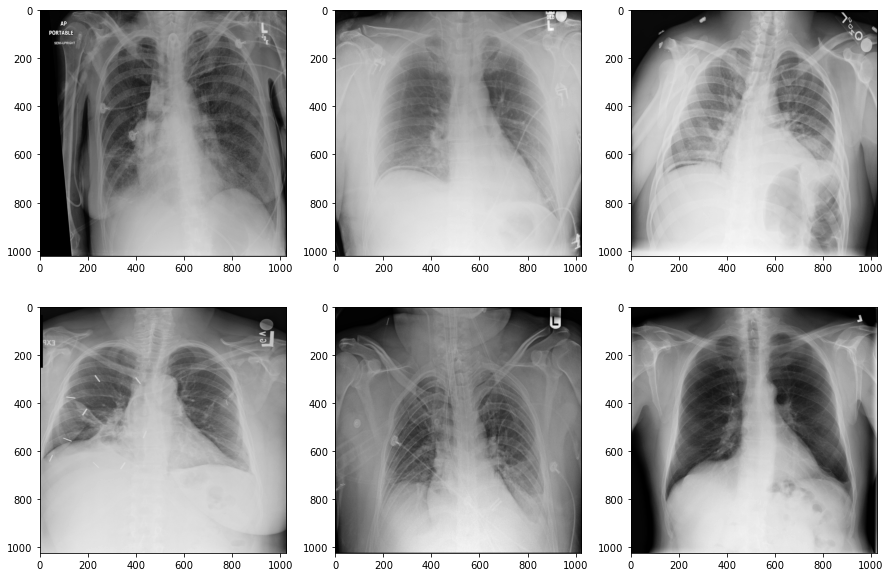

In [52]:
atelectasis_images = get_images(all_xray_df, 'path', 'Finding Labels', "Atelectasis", 6)
show_sample_plots(atelectasis_images, 2, 3)

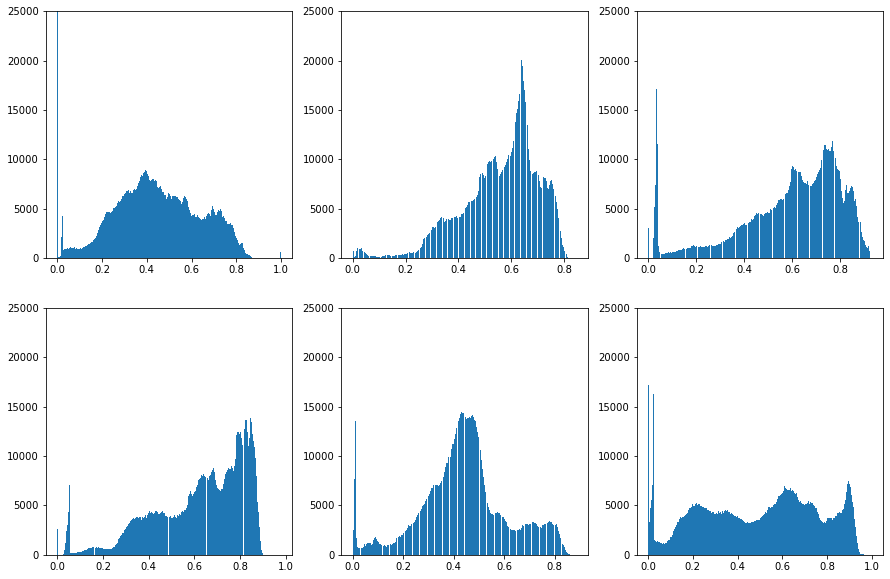

In [53]:
show_pixel_intensity_plots(atelectasis_images, 2, 3)

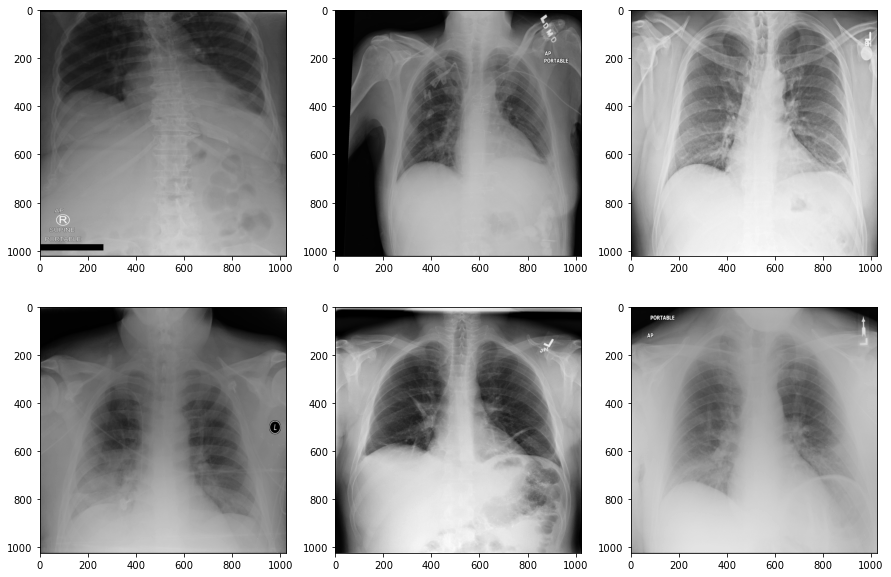

In [54]:
effusion_images = get_images(all_xray_df, 'path', 'Finding Labels', "Atelectasis", 6)
show_sample_plots(effusion_images, 2, 3)

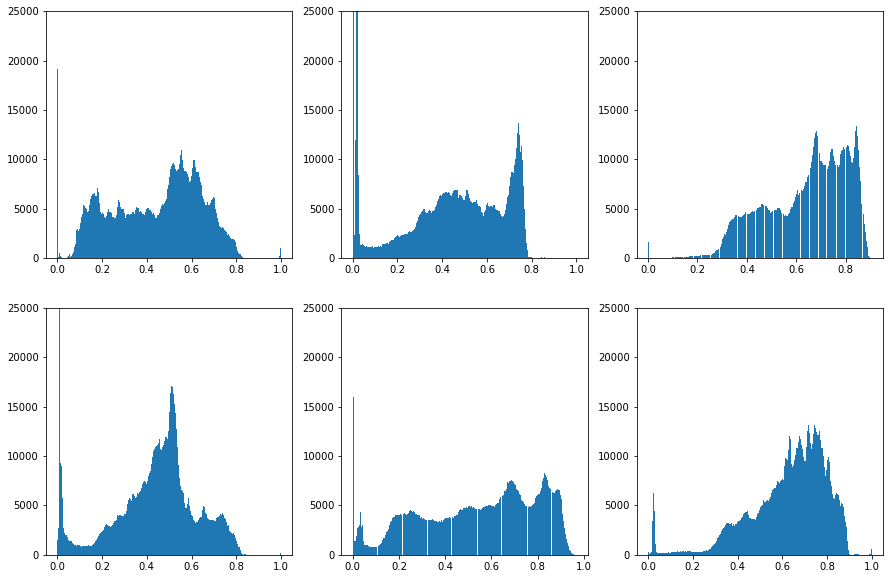

In [55]:
show_pixel_intensity_plots(effusion_images, 2, 3)

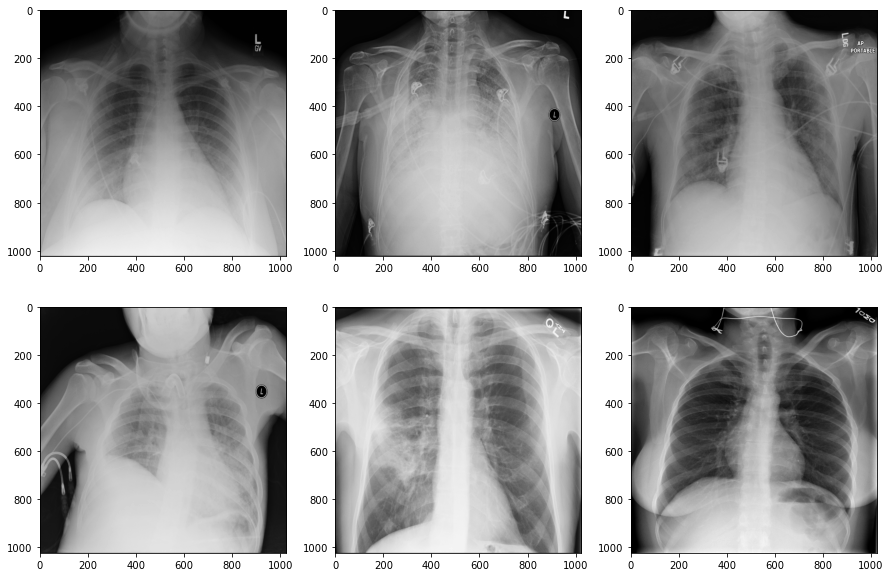

In [56]:
infiltration_images = get_images(all_xray_df, 'path', 'Finding Labels',  "Infiltration" , 6)
show_sample_plots(infiltration_images, 2, 3)

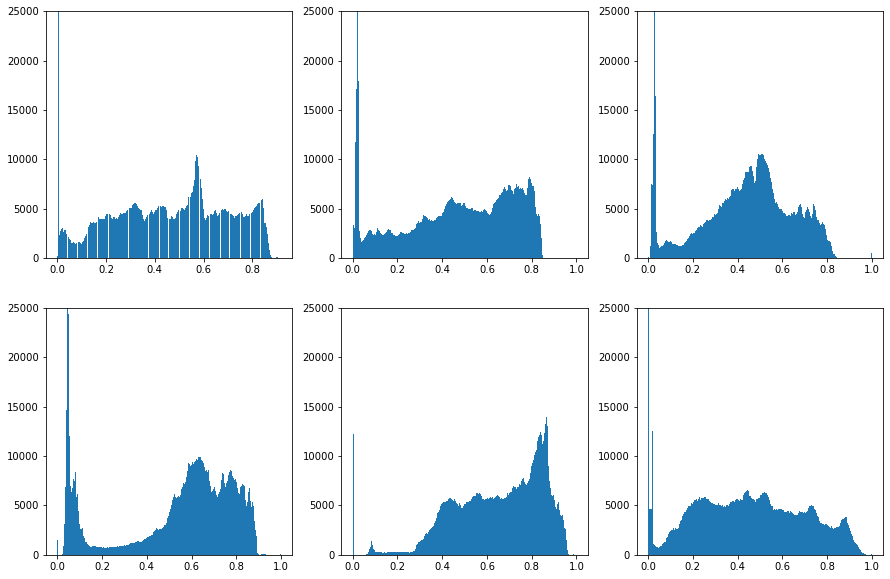

In [57]:
show_pixel_intensity_plots(infiltration_images, 2, 3)

Among them,  the pixel intensity profile  of 'Atelectasis' is most similar to 'Pneumonia', and again, the pixel intensity profiles varied within group.

## Conclusions

1. There are 112120 records in the dataset. 0.1% of the `Patient Age` in the dataset is invalid and need to be dropped before model training.
2. The age, gender and view postion distribution is similar between pneumonia positive dataset and the original dataset. We do not need to ajust the demographic  distribution before model training.
3. 43% of the `Patient ID` got more than 1 image in the dataset, to prevent data leakage we need to split the dataset based on `Patient ID` before model training.
4. `Pneumonia` positive ratio (1.27% ) is pretty small in the dataset. We need to ajust the positive ratio of `Pneumonia`  in the dataset before model training.
5. The other disease distribution is similar between pneumonia positive dataset and the original dataset except `Edema`, suggesting a correlation bewteen `Edema` and `Pneumonia`.
6. The  pixel intensity profile is different between groups of `No Finding`, `Pneumonia` and other disease, and also varied within different groups.